# Import

In [1]:
import pandas as pd
import gtfs_kit as gk
import helper #homemade function file helper.py
import warnings
import numpy as np
import json

import seaborn as sns
import os
from datetime import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score 
from math import sqrt
from sklearn.metrics import classification_report
import matplotlib
import matplotlib.pyplot as plt
import joblib

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [2]:
#Settings
setting_date = '20231106'
weather_setting_date = '2023-11-06T'
ritardo_partenza_treno = 4

# Preprocessing

### GTFS Static Preprocessing

In [3]:
feed = gk.feed.read_feed('../../feed_collection/20221214.gtfs',dist_units="km")

#Datasets Creation
routes,stop_times,trips = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
stops,shapes,calendar_dates = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

In [4]:
# Selecting Pisa Lucca Aulla
routes_feed,stop_times_feed,trips_feed = feed.routes, feed.stop_times, feed.trips 
stops_feed,shapes_feed,calendar_dates_feed = feed.stops , feed.shapes, feed.calendar_dates
    
### Get the route information for Routes where route is Pisa-Lucca-Aulla and usefull ids
sub_routes = routes_feed.loc[routes_feed['route_long_name'] == 'Pisa - Lucca - Aulla'].reset_index(drop=True)
routes = pd.concat([routes, sub_routes])
route_id = sub_routes.iloc[0]['route_id']

### Get all the trips in for Pisa-Lucca-Aulla
sub_trips = trips_feed.loc[trips_feed['route_id'] == route_id].reset_index(drop=True)
trips = pd.concat([trips, sub_trips]).reset_index(drop=True)

### Get all the stops time regarding the Pisa-Lucca-Aulla 
sub_stop_times = pd.merge(sub_trips, stop_times_feed, on=['trip_id','trip_id']).reset_index(drop=True)
sub_stop_times = sub_stop_times.drop(['route_id', 'service_id','trip_headsign', 'trip_short_name','direction_id', 'shape_id'], axis=1)
stop_times = pd.concat([stop_times, sub_stop_times]).reset_index(drop=True)

### Get all the stops of the Pisa-Lucca-Aulla route
sub_stops = pd.merge(sub_stop_times,stops_feed, on=['stop_id','stop_id']).reset_index(drop=True)
sub_stops = sub_stops.drop(['trip_id', 'arrival_time','departure_time', 'stop_sequence','shape_dist_traveled'], axis=1)
stops = pd.concat([stops, sub_stops]).reset_index(drop=True)

### Get all the shapes related with the Pisa-Lucca-Aulla trips
sub_shapes = pd.merge(sub_trips, shapes_feed, on=['shape_id','shape_id']).reset_index(drop=True)
sub_shapes = sub_shapes.drop(['route_id', 'service_id','trip_headsign', 'trip_short_name','direction_id', 'trip_id'], axis=1)
shapes = pd.concat([shapes, sub_shapes]).reset_index(drop=True)

### Get all the calendar dates related with the Pisa-Lucca-Aulla trips
sub_dates = pd.merge(sub_trips, calendar_dates_feed, on=['service_id','service_id']).reset_index(drop=True)
sub_dates = sub_dates.drop(['route_id', 'shape_id','trip_headsign', 'trip_short_name','direction_id', 'trip_id'], axis=1)
calendar_dates = pd.concat([calendar_dates, sub_dates]).reset_index(drop=True)

### Clean dataset
routes = routes.drop_duplicates().reset_index(drop=True)
trips = trips.drop_duplicates().reset_index(drop=True)
stops = stops.drop_duplicates().reset_index(drop=True)
stop_times = stop_times.drop_duplicates().reset_index(drop=True)
shapes = shapes.drop_duplicates().reset_index(drop=True)
calendar_dates = calendar_dates.drop_duplicates().reset_index(drop=True)
calendar_dates = calendar_dates.drop(['exception_type'], axis=1)

# Delete the stops not delonging to our railway line 
stops_id_to_delete = ["S06725_1","S06506_1","S06505_1","S06504_1","S06502_1","S06351_1","S06350_1","S06040_1"]
for stops_to_delete in stops_id_to_delete:
    stops = stops[stops.stop_id != stops_to_delete]
    
main_dataset = stop_times.copy()
main_dataset = pd.merge(main_dataset, trips, on=['trip_id','trip_id']).reset_index(drop=True)
main_dataset = pd.merge(main_dataset, calendar_dates, on=['service_id','service_id']).reset_index(drop=True)
main_dataset = pd.merge(main_dataset, stops, on=['stop_id','stop_id']).reset_index(drop=True)
main_dataset = main_dataset.drop(['route_id', 'service_id','trip_headsign', 'shape_id','stop_name'], axis=1)

main_dataset.sort_values('trip_short_name',ascending=False)
main_dataset = main_dataset.rename(columns={'trip_short_name': 'codice','stop_id':'codice_stazione','date':'data_giorno'})
main_dataset = main_dataset.loc[(main_dataset["data_giorno"] == setting_date)]

In [5]:
# Clean memory
del stops,stops_to_delete,calendar_dates,shapes,stop_times,trips,routes
del sub_dates,sub_shapes,sub_stops,sub_routes

### Weather Preprocessing


In [6]:
locations = pd.read_csv('../../weather/locations.csv')
temp_mesurments = pd.read_csv('../../weather/november.csv')
mappa_location_codice = helper.mappaloccodice()
hours_of_the_day =  helper.hours_of_the_day()
measurments = pd.DataFrame()

for i in range(len(hours_of_the_day)):
    temp_date = weather_setting_date + hours_of_the_day[i] +":00" 
    temp = temp_mesurments.loc[(temp_mesurments['time'] == temp_date)]
    measurments = pd.concat([measurments, temp], ignore_index=True)

locations["codice_stazione"] = locations["location_id"].apply(lambda x: mappa_location_codice.get(x))
measurments["codice_stazione"] = measurments["location_id"].apply(lambda x: mappa_location_codice.get(x))
measurments = measurments.assign(data_giorno=None)
measurments = measurments.assign(orario=None)

In [7]:
for index, row  in measurments.iterrows():
    date,time = measurments.loc[index,"time"].split("T")
    measurments.loc[index,'orario'] = time
    measurments.loc[index,'data_giorno'] = date.replace("-","")


In [8]:
measurments = measurments.rename(columns={'temperature_2m (°C)': 'temperature',
                                          'apparent_temperature (°C)' : 'app_temp',
                                          'relative_humidity_2m (%)' : 'humidity',
                                          'precipitation (mm)' : 'precipitation',
                                          'rain (mm)' : 'rain', 
                                          'snowfall (cm)':'snow_fall',
                                          'snow_depth (m)':'snow_depth',
                                          'weather_code (wmo code)' : 'wmo_code',
                                          'wind_speed_10m (km/h)':'wind_speed_10m',
                                          'wind_speed_100m (km/h)':'wind_speed_100m',
                                          'wind_direction_10m (°)':'wind_dir_10m',
                                          'wind_direction_100m (°)':'wind_dir_100m',
                                          'wind_gusts_10m (km/h)' : 'wind_gusts',
                                          'soil_temperature_0_to_7cm (°C)':'soil_temperature'
                                         })

measurments['data_giorno'] = measurments['data_giorno'].astype(str)
weather = measurments.copy()
weather['data_giorno'] = weather['data_giorno'].astype(str)

In [9]:
# Clean memory
del locations, temp, measurments

### Delays Preprocessing

In [10]:
lista_fermate = helper.get_lista_fermate()
mappa_location_codice = helper.get_nome_codice_loc()
directory = '../../realtime_data_testing'
#Read Files
delays_df =  pd.DataFrame(columns=['n','p','rp','a','ra','c','oaz','opz','op','oa','fr','pr','date'])
for filename in os.listdir(directory):
    file = os.path.join(directory, filename)
    if os.path.isfile(file):
        f = open(file) 
        data = json.load(f)
        giorno = f.name[33:43].split('_')
        date_to_add = giorno[2] + giorno[1] + giorno[0]
        df = pd.DataFrame(data['treni'])
        df = df[df.p.isin(lista_fermate) & df.a.isin(lista_fermate)]
        df = df.reset_index(drop=True)
        df['date'] = date_to_add
        df.dropna(axis=1, how='all')
        delays_df = pd.concat([delays_df, df]).reset_index(drop=True)
#Read 
delays_df = delays_df.rename(columns={'n': 'codice', 'p': 'punto_partenza','rp':'ritardo_partenza','a':'punto_arrivo',
                                     'ra':'ritardo_arrivo','c':'categoria'})
delays_df.dropna(axis=1, how='all')
delays_df = delays_df.reset_index(drop=True)

for index, row in delays_df.iterrows():
    if(pd.notnull(delays_df['cn'][index])):
        value = delays_df.loc[index,'cn'].split(",")
        delays_df.loc[index,'codice'] = row['codice']+"*"+value[0]

In [11]:
# We now expand the dataset by having trip_id, date, station
delays_expanded = pd.DataFrame(columns=['codice','data_giorno','codice_stazione','opt','oat'])
max_val = delays_df.index.max()
for index, row  in delays_df.iterrows():
    if(index % 1000 == 0):
        print("row " + str(index) + "/" +str(max_val))
    json_to_put_in_table = str(delays_df.loc[index, 'fr']).replace("'","\"")
    if(json_to_put_in_table != "nan"):
        temp_dictionary = json.loads(json_to_put_in_table)
        df = pd.DataFrame(temp_dictionary)
        df['codice'] = row['codice']
        df['data_giorno'] = row['date']
        df.oa = df.oa.apply(lambda x: datetime.fromtimestamp(x).time())
        df.op = df.op.apply(lambda x: datetime.fromtimestamp(x).time())
        delays_expanded = pd.concat([delays_expanded, df]).reset_index(drop=True)
    else:   
        row_partenza = {'codice': row['codice'], 'data_giorno':row['date'],'codice_stazione':'', 'n':row['punto_partenza'], 
                        'ra': 'N', 'rp' : row['ritardo_partenza'],'oa': 0,'op': datetime.fromtimestamp(row['op']).time() }
        row_arrivo = {'codice': row['codice'], 'data_giorno':row['date'], 'codice_stazione':'','n':row['punto_arrivo'], 
                        'ra': row['ritardo_arrivo'] , 'rp' : 'N','oa': datetime.fromtimestamp(row['oa']).time(),'op': 0 }
        delays_expanded = pd.concat([delays_expanded, pd.DataFrame([row_partenza])], ignore_index=True)
        delays_expanded = pd.concat([delays_expanded, pd.DataFrame([row_arrivo])], ignore_index=True)

row 0/200


In [12]:
delays_expanded = delays_expanded.rename(columns={'n': 'stazione', 'ra': 'ritardo_arrivo',
                                                  'rp':'ritardo_partenza','oa':'orario_arrivo',
                                                  'op':'orario_partenza'})
 
delays_expanded["codice_stazione"] = delays_expanded["stazione"].apply(lambda x: mappa_location_codice.get(x))
delays_expanded = delays_expanded.drop(['stazione'], axis=1)

delays = delays_expanded.copy()
delays["codice"] = delays["codice"].astype(str)
delays["data_giorno"] = delays["data_giorno"].astype(str)

In [13]:
# Clean Memory
del delays_expanded,delays_df,data

In [14]:
# Join and Clean
main_dataset = pd.merge(main_dataset, delays, on=['codice', 'data_giorno','codice_stazione'])

#Calcolo orario arrotondato per join con weather.
main_dataset['orario'] = main_dataset.loc[:, 'arrival_time']
max_index_for_display = main_dataset.index.max()
for index, row  in tqdm(main_dataset.iterrows()):
    orario_to_split = main_dataset.loc[index,"orario"].split(":")
    if orario_to_split[1] >= "30":
        orario_to_split[0]= str( int(orario_to_split[0]) + 1 )
    main_dataset.loc[index,"orario"] = orario_to_split[0] + ":00"
    
#Join on Weather
main_dataset = pd.merge(main_dataset, weather, on=['data_giorno','orario','codice_stazione'])

181it [00:00, 18023.96it/s]


In [15]:
# Clean for memory
del weather, delays

In [16]:
main_dataset = main_dataset.sort_values(['trip_id','data_giorno','stop_sequence'],ascending=True)


In [17]:
main_dataset = main_dataset.loc[(main_dataset.trip_id != "4118_296528") & (main_dataset.trip_id != "4118_296529")]

In [18]:
main_dataset

,trip_id,arrival_time,departure_time,codice_stazione,stop_sequence,shape_dist_traveled,codice,direction_id,data_giorno,stop_lat,...,rain,snow_fall,snow_depth,wmo_code,wind_speed_10m,wind_speed_100m,wind_dir_10m,wind_dir_100m,wind_gusts,soil_temperature
6,4118_296532,15:52:00,15:52:00,S06404_1,1,0.00000,19210,0,20231106,43.837397,...,0.0,0.0,0.0,1,13.6,23.4,238,239,31.0,18.1
80,4118_296532,15:59:00,16:04:00,S06313_1,2,5.23393,19210,0,20231106,43.875088,...,0.0,0.0,0.0,1,8.3,16.9,252,254,27.7,17.4
88,4118_296532,16:08:00,16:09:00,S06312_1,3,9.08714,19210,0,20231106,43.908382,...,0.0,0.0,0.0,1,8.3,16.9,252,254,27.7,17.3
100,4118_296532,16:15:00,16:16:00,S06310_1,4,16.41975,19210,0,20231106,43.959490,...,0.0,0.0,0.0,1,7.3,14.1,259,255,23.4,16.8
110,4118_296532,16:20:00,16:21:00,S06309_1,5,19.92630,19210,0,20231106,43.977306,...,0.0,0.0,0.0,1,7.3,14.1,259,255,23.4,16.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,4118_296638,17:42:00,17:42:00,S06404_1,1,0.00000,18594,0,20231106,43.837397,...,0.0,0.0,0.0,1,9.6,22.5,250,248,19.4,16.7
171,4118_296638,17:48:00,17:49:00,S06402_1,2,8.01853,18594,0,20231106,43.821737,...,0.0,0.0,0.0,1,9.6,22.5,250,248,19.4,16.7
45,4118_296638,17:57:00,17:58:00,S06400_1,3,14.83468,18594,0,20231106,43.764855,...,0.0,0.0,0.0,1,7.0,20.2,258,254,23.8,16.9
52,4118_296638,18:07:00,18:08:00,S06501_1,4,20.90887,18594,0,20231106,43.723446,...,0.0,0.0,0.0,1,7.3,20.3,261,257,13.7,16.6


In [19]:
#Sort Dataset
main_dataset = main_dataset.sort_values(['trip_id','data_giorno','stop_sequence'],ascending=True)
main_dataset = main_dataset.reset_index(drop=True)

# We create an empty column for time different, speed, distance 
main_dataset = main_dataset.assign(temperature_linea=None)
main_dataset = main_dataset.assign(app_temp_linea=None)
main_dataset = main_dataset.assign(rain_linea=None)
main_dataset = main_dataset.assign(snow_fall_linea=None)
main_dataset = main_dataset.assign(snow_depth_linea=None)
main_dataset = main_dataset.assign(humidity_linea=None)
main_dataset = main_dataset.assign(precipitation_linea=None)
main_dataset = main_dataset.assign(wmo_code_linea=None)
main_dataset = main_dataset.assign(wind_speed_10m_linea=None)
main_dataset = main_dataset.assign(wind_speed_100m_linea=None)
main_dataset = main_dataset.assign(wind_dir_10m_linea=None)
main_dataset = main_dataset.assign(wind_dir_100m_linea=None)
main_dataset = main_dataset.assign(wind_gusts_linea=None)
main_dataset = main_dataset.assign(soil_temperature_linea=None)

max_index_for_display = main_dataset.index.max()

for index, row  in tqdm(main_dataset.iterrows()):
    if row['stop_sequence'] == 1:
        main_dataset['temperature_linea'][index] = row['temperature']
        main_dataset['app_temp_linea'][index] = row['app_temp']
        main_dataset['rain_linea'][index] = row['rain']
        main_dataset['snow_fall_linea'][index] = row['snow_fall']
        main_dataset['snow_depth_linea'][index] = row['snow_depth']
        main_dataset['humidity_linea'][index] = row['humidity']
        main_dataset['precipitation_linea'][index] = row['precipitation']
        main_dataset['wind_speed_10m_linea'][index] = row['wind_speed_10m']
        main_dataset['wind_speed_100m_linea'][index] = row['wind_speed_100m']
        main_dataset['wind_dir_10m_linea'][index] = row['wind_dir_10m']
        main_dataset['wind_dir_100m_linea'][index] = row['wind_dir_100m']
        main_dataset['wmo_code_linea'][index] = row['wmo_code']
        main_dataset['wind_gusts_linea'][index] = row['wind_gusts']
        main_dataset['soil_temperature_linea'][index] = row['soil_temperature']
    else:
        main_dataset['temperature_linea'][index] = ((row['temperature'] + main_dataset.loc[index - 1,'temperature']) / 2) 
        main_dataset['app_temp_linea'][index] = ((row['app_temp'] + main_dataset.loc[index - 1,'app_temp']) / 2) 
        main_dataset['rain_linea'][index] = ((row['rain'] + main_dataset.loc[index - 1,'rain']) / 2) 
        main_dataset['snow_fall_linea'][index] = ((row['snow_fall'] + main_dataset.loc[index - 1,'snow_fall']) / 2) 
        main_dataset['snow_depth_linea'][index] = ((row['snow_depth'] + main_dataset.loc[index - 1,'snow_depth']) / 2) 
        main_dataset['precipitation_linea'][index] = ((row['precipitation'] + main_dataset.loc[index - 1,'precipitation']) / 2) 
        main_dataset['humidity_linea'][index] = ((row['humidity'] + main_dataset.loc[index - 1,'humidity']) / 2)
        main_dataset['wind_speed_10m_linea'][index] = ((row['wind_speed_10m'] + main_dataset.loc[index - 1,'wind_speed_10m']) / 2) 
        main_dataset['wind_speed_100m_linea'][index] =((row['wind_speed_100m'] + main_dataset.loc[index - 1,'wind_speed_100m']) / 2)  
        main_dataset['wind_dir_10m_linea'][index] = ((row['wind_dir_10m'] + main_dataset.loc[index - 1,'wind_dir_10m']) / 2) 
        main_dataset['wind_dir_100m_linea'][index] = ((row['wind_dir_100m'] + main_dataset.loc[index - 1,'wind_dir_100m']) / 2)
        main_dataset['wmo_code_linea'][index] = ((row['wmo_code'] + main_dataset.loc[index - 1,'wmo_code']) / 2) 
        main_dataset['wind_gusts_linea'][index] = ((row['wind_gusts'] + main_dataset.loc[index - 1,'wind_gusts']) / 2) 
        main_dataset['soil_temperature_linea'][index] = ((row['soil_temperature'] + main_dataset.loc[index - 1,'soil_temperature']) / 2)

160it [00:00, 1048.66it/s]


In [20]:
# Drop Duplicates
row_to_delete =[]  
# Change orario realtime arrivo stazione 1 (non c'è to = arrivo_schedulato)
for index, row  in tqdm(main_dataset.iterrows()):
    # X nessun ritardo, N significa che non riparte perché era l'ultima destinazione oppure quella di partenza
    if((row['ritardo_arrivo'] == 'X') |( row['ritardo_arrivo'] == 'N')):
        main_dataset.loc[index,"ritardo_arrivo"] = '0'
    if((row['ritardo_partenza'] == 'X' )| (row['ritardo_partenza'] == 'N')):
        main_dataset.loc[index,"ritardo_partenza"] = '0'
    if((row['ritardo_arrivo'] == 'S') | (row['ritardo_arrivo'] == 'n.d.')):
        row_to_delete.append(index)
    if((row['ritardo_partenza'] == 'S') | (row['ritardo_partenza'] == 'n.d.')):
        row_to_delete.append(index)

row_to_delete = list(dict.fromkeys(row_to_delete))
main_dataset = main_dataset[~main_dataset.index.isin(row_to_delete)]
main_dataset.reset_index(drop=True)

main_dataset["ritardo_partenza"] = main_dataset["ritardo_partenza"].astype(int)
main_dataset["ritardo_arrivo"] = main_dataset["ritardo_arrivo"].astype(int)
max_index_for_display = main_dataset.index.max()

for index, row  in tqdm(main_dataset.iterrows()):
    main_dataset.loc[index,'arrival_time'] = row['arrival_time'].replace(':','')
    main_dataset.loc[index,'departure_time'] = row['departure_time'].replace(':','')
    main_dataset.loc[index,'stop_code'] = row['stop_code'].replace('S','')
    main_dataset.loc[index,'time_diff'] = 0
    main_dataset.loc[index,'dist_diff'] = 0
    main_dataset.loc[index,'speed'] = 0
    
    if row['ritardo_arrivo'] < 0:
        main_dataset.loc[index,'ritardo_arrivo'] = 0
    if row['ritardo_partenza'] < 0:
        main_dataset.loc[index,'ritardo_partenza'] = 0


160it [00:00, 34952.53it/s]
160it [00:00, 6848.68it/s]


In [21]:
df_linea =  pd.DataFrame(columns=['trip_id','arrival_time','departure_time','codice_stazione_p',
                                  'codice_stazione_a','indice_tratta','shape_dist_traveled',
                                  'time_diff','speed','dist_diff','codice','direction_id','data_giorno',
                                  'stop_code_p','stop_code_a','ritardo_partenza','ritardo_arrivo',
                                  'temperature_linea','app_temp_linea','rain_linea','snow_fall_linea','snow_depth_linea','humidity_linea',
                                  'precipitation_linea','wmo_code_linea','wind_speed_10m_linea','wind_speed_100m_linea',
                                  'wind_dir_10m_linea','wind_dir_100m_linea','wind_gusts_linea','soil_temperature_linea'])

In [22]:
# Calculating Distance, Time and avg Speed between last stop and current stop
max_val = main_dataset.index.max()
for index, row  in tqdm(main_dataset.iterrows()):
    if(index < max_val):
        next_row = main_dataset.iloc[[index+1]]
        check1 = (next_row['trip_id'] == row['trip_id']).bool()
        check2 = (next_row['data_giorno'] == row['data_giorno']).bool()
        if(check1 & check2):
            row_to_concat = {'trip_id': row['trip_id'],
                             'departure_time':row['departure_time'],
                             'arrival_time':next_row['arrival_time'].values,
                             'codice_stazione_p':row['codice_stazione'],
                             'codice_stazione_a': next_row['codice_stazione'].values[0],
                             'indice_tratta':row['stop_sequence'],
                             'shape_dist_traveled':next_row['shape_dist_traveled'].values,
                             'time_diff':next_row['time_diff'].values,
                             'speed':next_row['speed'].values,
                             'dist_diff':next_row['dist_diff'].values,
                             'codice':row['codice'],
                             'direction_id':row['direction_id'],
                             'data_giorno':row['data_giorno'],
                             'stop_code_p':row['stop_code'],
                             'stop_code_a':next_row['stop_code'].values[0],
                             'ritardo_partenza':row['ritardo_partenza'],
                             'ritardo_arrivo':next_row['ritardo_arrivo'].values,
                             'temperature_linea':next_row['temperature_linea'].values,
                             'app_temp_linea':next_row['app_temp_linea'].values,
                             'rain_linea':next_row['rain_linea'].values,
                             'snow_fall_linea':next_row['snow_fall_linea'].values,
                             'snow_depth_linea':next_row['snow_depth_linea'].values,
                             'humidity_linea':next_row['humidity_linea'].values,
                             'precipitation_linea':next_row['precipitation_linea'].values,
                             'wmo_code_linea':next_row['wmo_code_linea'].values,
                             'wind_speed_10m_linea':next_row['wind_speed_10m_linea'].values,
                             'wind_speed_100m_linea':next_row['wind_speed_100m_linea'].values,
                             'wind_dir_10m_linea':next_row['wind_dir_10m_linea'].values,
                             'wind_dir_100m_linea':next_row['wind_dir_100m_linea'].values,
                             'wind_gusts_linea': next_row['wind_gusts_linea'].values,
                             'soil_temperature_linea':next_row['soil_temperature_linea'].values
                        }    
            df_linea = pd.concat([df_linea, pd.DataFrame([row_to_concat])], ignore_index=True)

160it [00:00, 1284.45it/s]


In [23]:
df_linea['arrival_time'] = df_linea['arrival_time'].astype(int)
#df_linea['codice_stazione_a'] = 
df_linea['shape_dist_traveled'] = df_linea['shape_dist_traveled'].astype(float)
df_linea['time_diff'] = df_linea['time_diff'].astype(float)
df_linea['speed'] = df_linea['speed'].astype(float)
df_linea['dist_diff'] = df_linea['dist_diff'].astype(float)
#df_linea['stop_code_a'] = df_linea['stop_code_a'].transform(lambda x: ','.join(x))
df_linea['ritardo_arrivo'] = df_linea['ritardo_arrivo'].astype(int)
df_linea['temperature_linea'] = df_linea['temperature_linea'].astype(float)
df_linea['app_temp_linea'] = df_linea['app_temp_linea'].astype(float)
df_linea['rain_linea'] = df_linea['rain_linea'].astype(float)
df_linea['snow_fall_linea'] = df_linea['snow_fall_linea'].astype(float)
df_linea['snow_depth_linea'] = df_linea['snow_depth_linea'].astype(float)
df_linea['humidity_linea'] = df_linea['humidity_linea'].astype(float)
df_linea['precipitation_linea'] = df_linea['precipitation_linea'].astype(float)
df_linea['wmo_code_linea'] = df_linea['wmo_code_linea'].astype(float)
df_linea['wind_speed_10m_linea'] = df_linea['wind_speed_10m_linea'].astype(float)
df_linea['wind_speed_100m_linea'] = df_linea['wind_speed_100m_linea'].astype(float)
df_linea['wind_dir_10m_linea'] = df_linea['wind_dir_10m_linea'].astype(float)
df_linea['wind_dir_100m_linea'] = df_linea['wind_dir_100m_linea'].astype(float)
df_linea['wind_gusts_linea'] = df_linea['wind_gusts_linea'].astype(float)
df_linea['soil_temperature_linea'] = df_linea['soil_temperature_linea'].astype(float)
df_linea['departure_time'] = df_linea['departure_time'].astype(int)
df_linea['indice_tratta'] = df_linea['indice_tratta'].astype(int)
df_linea['codice'] = df_linea['codice'].astype(int)
df_linea['direction_id'] = df_linea['direction_id'].astype(int)
df_linea['data_giorno'] = df_linea['data_giorno'].astype(int)
df_linea['stop_code_a'] = df_linea['stop_code_a'].astype(int)
df_linea['stop_code_p'] = df_linea['stop_code_p'].astype(int)
df_linea['ritardo_partenza'] = df_linea['ritardo_partenza'].astype(int)
df_linea['ritardo_arrivo'] = df_linea['ritardo_arrivo'].astype(int)
df_linea['wind_dir_10m_linea'] = df_linea['wind_dir_10m_linea'].astype(int)

In [24]:
del main_dataset

In [25]:
df_linea = df_linea.reset_index(drop=True)
main_dataset = df_linea.copy()
main_dataset = main_dataset.assign(isArrivoRitardo=0)
main_dataset = main_dataset.assign(isPartenzaRitardo=0)
for index,row in main_dataset.iterrows():
    if ((row['ritardo_partenza'] >= 1)):
        main_dataset.loc[index,'isPartenzaRitardo'] = 1
    if ((row['ritardo_arrivo'] >= 1)):
        main_dataset.loc[index,'isArrivoRitardo'] = 1
del df_linea

### Matrix 28x28

In [26]:
#Load tables
distance = pd.read_csv('../csv/distance_matrix.csv',index_col=[0])
time =  pd.read_csv('../csv/time_matrix.csv',index_col=[0])
speed = pd.read_csv('../csv/speed_matrix.csv',index_col=[0]) 

In [27]:
for index,row in main_dataset.iterrows():
    main_dataset.loc[index,'dist_diff'] = distance.loc[row['codice_stazione_p']][row['codice_stazione_a']]
    main_dataset.loc[index,'time_diff'] = time.loc[row['codice_stazione_p']][row['codice_stazione_a']]
    main_dataset.loc[index,'speed'] = speed.loc[row['codice_stazione_p']][row['codice_stazione_a']]
del distance,time,speed

In [28]:
main_dataset = main_dataset.round({'speed':0,'temperature_linea':0,'wind_dir_10m_linea':0,'soil_temperature_linea':0 ,
                                  'wind_gusts_linea':0, 'wind_dir_100m_linea':0 ,'wind_speed_100m_linea':0,
                                  'wind_speed_10m_linea':0, 'wmo_code_linea':0 , 'humidity_linea':0}) 

labelEncoder = LabelEncoder()
main_dataset["trip_id"] = labelEncoder.fit_transform(main_dataset["trip_id"])
main_dataset = main_dataset.drop(['codice_stazione_p','codice_stazione_a'], axis=1)
main_dataset["isArrivoRitardo"] = main_dataset["isArrivoRitardo"].astype(float)
main_dataset["isPartenzaRitardo"] = main_dataset["isPartenzaRitardo"].astype(float)

trip_ids = set(main_dataset.trip_id)
mdf_copy = main_dataset.copy()
main_dataset = main_dataset.assign(classification_prevision_on_row=0)
main_dataset = main_dataset.assign(regression_prevision_on_row=0)
main_dataset = main_dataset.assign(classification_prevision_on_train=0)
main_dataset = main_dataset.assign(regression_prevision_on_train=0)

In [29]:
mdf_copy.to_csv("mdf.csv")

In [30]:
classificator =  joblib.load("./models/under_sampling/RandomForestClassifier.joblib")
regressor = joblib.load("./models/regressions/RandomForestRegressor.joblib")

### Classifing and Predict each line of each trip

In [31]:
X = mdf_copy.drop(['isArrivoRitardo','ritardo_arrivo'], axis=1)


In [32]:
for i in trip_ids:
    df = X.loc[(X.trip_id == i)]
    df.reset_index(drop=True)
    if(not df.empty):
        for index, row in df.iterrows():
                #Classification i < max index
                value = classificator.predict([row.values])
                main_dataset.loc[(main_dataset.trip_id == i) & 
                                 (main_dataset.indice_tratta == row['indice_tratta']),
                        'classification_prevision_on_row'] = value
                
                df.loc[(df.trip_id == i) & (df.indice_tratta == row['indice_tratta']),
                        'isArrivoRitardo'] = value
                
                #Regression i < max index
                temp = df.loc[index:index].copy()
                temp.drop(columns=["trip_id","indice_tratta","codice","data_giorno"
                                         ], inplace=True)
                
                if(value > 0 ):
                    rit_val = regressor.predict(temp.values)
                    main_dataset.loc[(main_dataset.trip_id == i) & (main_dataset.indice_tratta == row['indice_tratta']),
                                    'regression_prevision_on_row'] = rit_val
                    #df.loc[index+1,'ritardo_partenza'] = rit_val
                    df = df.drop(['isArrivoRitardo'], axis=1)
    else:
        main_dataset = main_dataset.loc[(main_dataset.trip_id != i)]

In [33]:
del row,df,X,temp

# Result

In [34]:
result= main_dataset.copy()

In [35]:
result.drop(columns=["arrival_time","departure_time","shape_dist_traveled","time_diff",
                     "speed","dist_diff","codice","direction_id","data_giorno",
                     "temperature_linea","app_temp_linea","rain_linea","snow_fall_linea","snow_depth_linea","humidity_linea",
                     "precipitation_linea","wmo_code_linea","wind_speed_10m_linea","wind_speed_100m_linea",
                     "wind_dir_10m_linea","wind_dir_100m_linea",
                     "wind_gusts_linea","soil_temperature_linea"
                                         ], inplace=True)

result['regression_prevision_on_row'] = round(result.regression_prevision_on_row,0)

result["regression_prevision_on_row"] = result["regression_prevision_on_row"].astype(int)

result["isPartenzaRitardo"] = result["isPartenzaRitardo"].astype(bool)
result["isArrivoRitardo"] = result["isArrivoRitardo"].astype(bool)
result["classification_prevision_on_row"] = result["classification_prevision_on_row"].astype(bool)


In [36]:
result.to_csv("result.csv")

In [37]:
actual = result.isArrivoRitardo.values
predicted = result.classification_prevision_on_row.values
print(classification_report(actual, predicted))                                                     

              precision    recall  f1-score   support

         0.0       0.66      0.78      0.71        40
         1.0       0.90      0.83      0.86        94

    accuracy                           0.81       134
   macro avg       0.78      0.80      0.79       134
weighted avg       0.83      0.81      0.82       134



In [38]:
n = len(result)
total_for_mae = 0
total_for_mse = []

# for loop for iteration 
for i in range(n): 
    if(result.loc[i, 'classification_prevision_on_row'] == 1): 
        value = result.loc[i,'ritardo_arrivo'] - result.loc[i,'regression_prevision_on_row']
        total_for_mae += abs(value)
        total_for_mse.append(value)

df = result.loc[(result['classification_prevision_on_row'] == 1)]
actual = df.ritardo_arrivo.values
predicted = df.regression_prevision_on_row.values


mae = total_for_mae/n 
mse = np.square(total_for_mse).mean()
rmse = sqrt(mse)

# display 
print("Mean absolute error : " + str(mae)) 
print("Mean squared error : " + str(mse))
print("Root mean squared error : " + str(rmse))

#del df,actual,predicted


Mean absolute error : 0.5935820895522388
Mean squared error : 2.2470988505747123
Root mean squared error : 1.4990326382619934


In [39]:
width = 12
height = 10

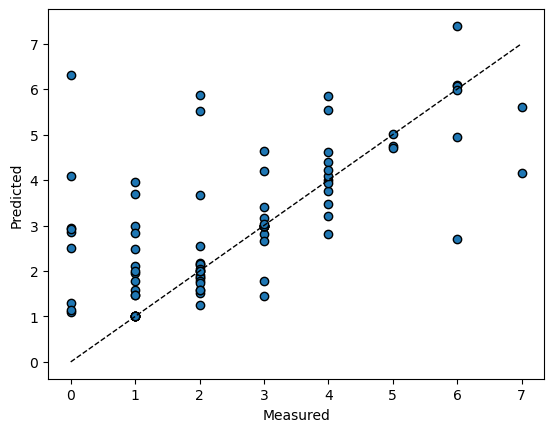

In [40]:
fig, ax = plt.subplots()
ax.scatter(actual, predicted, edgecolors=(0, 0, 0))
ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


/var/folders/zt/4qm_9p2d267_7b0p2r1hsg840000gn/T/ipykernel_12902/797627122.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(actual, hist=False, color="r", label="Actual Value")
/var/folders/zt/4qm_9p2d267_7b0p2r1hsg840000gn/T/ipykernel_12902/797627122.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed29744

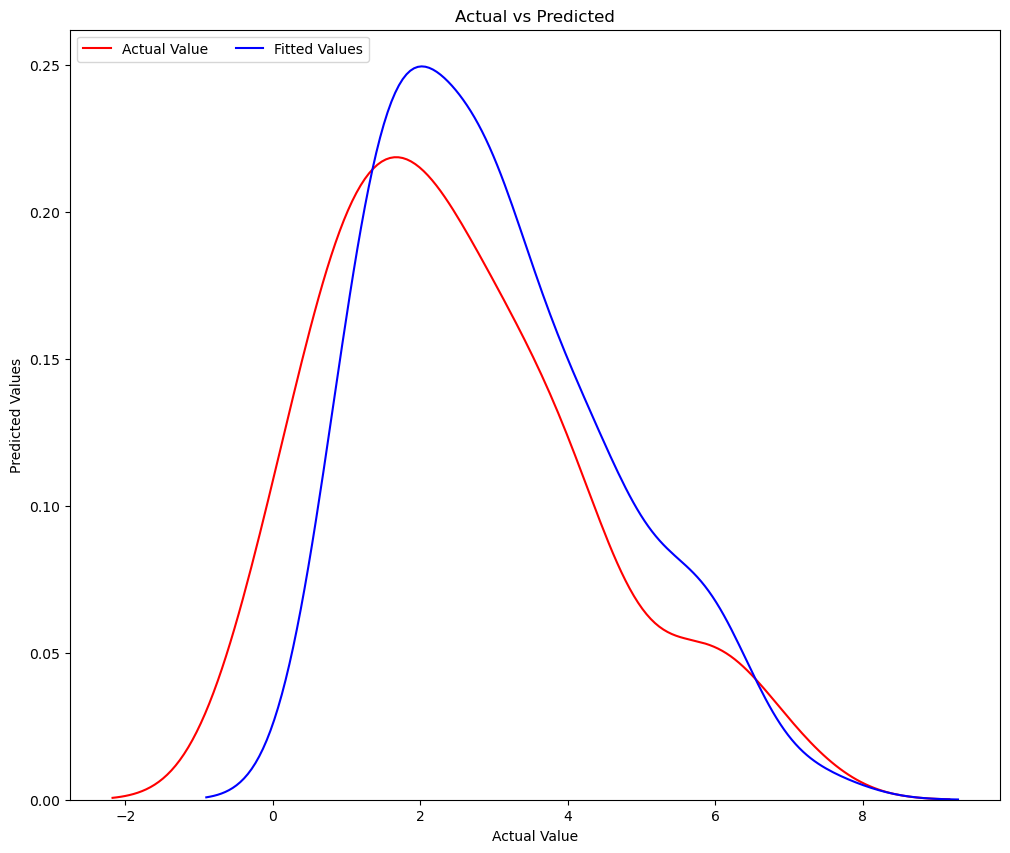

In [41]:
plt.figure(figsize=(width, height))


ax1 = sns.distplot(actual, hist=False, color="r", label="Actual Value")
sns.distplot(predicted, hist=False, color="b", label="Fitted Values" , ax=ax1)
ax1.legend(loc='upper left', ncols=2)


plt.title('Actual vs Predicted')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Values')

plt.show()
plt.close()

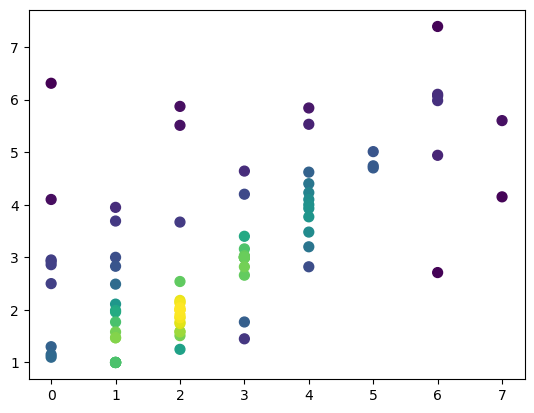

In [42]:
from scipy.stats import gaussian_kde
# Calculate the point density
xy = np.vstack([actual,predicted])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = actual[idx], predicted[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)

plt.show()


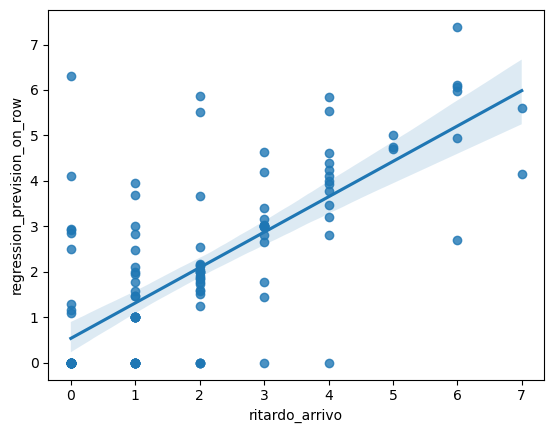

In [43]:
sns.regplot(x="ritardo_arrivo", y="regression_prevision_on_row", data=result);
